In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

from test_sampler import TestProblem, TestProblem2

In [117]:
def nesterov(x_0, grad, L, mu, K):
    x_cur = x_0
    y_cur = x_0
    x_list = [x_0]
    y_list = [x_0]
    for i in range(K):
        x_upd = y_cur - (1 / L) * (grad(y_cur, L))
        y_upd = x_upd + ((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))) * (x_upd - x_cur)

        x_list.append(x_upd)
        y_list.append(y_upd)

        x_cur = x_upd
        y_cur = y_upd

    return x_list, y_list



## Test problem 2

In [118]:
# test_problem = TestProblem(gamma=1e5)
test_problem = TestProblem2(La=1000, Lb=10)

x1_star = - np.linalg.pinv(test_problem.A) @ test_problem.a
x2_star = - np.linalg.pinv(test_problem.B) @ test_problem.b
# less stable
# x_star = np.linalg.solve(test_problem.A, -test_problem.a)
# y_star = np.linalg.solve(test_problem.B, -test_problem.b)

f_star = test_problem.calc(x1_star, x2_star)[0]
def f(x1, x2):
    return x1.T @ test_problem.A @ x1 / 2 + test_problem.a @ x1 + x2.T @ test_problem.B @ x2 / 2 + test_problem.b @ x2 

f_star, f(x1_star, x2_star)

(-1735.1681778757593, -1735.1681778757593)

## Test problem 1

In [122]:
test_problem = TestProblem(gamma=1e-6)

## ACRCD

100%|██████████| 20000/20000 [00:10<00:00, 1878.95it/s]


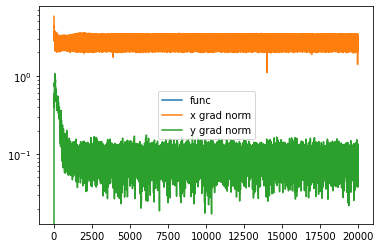

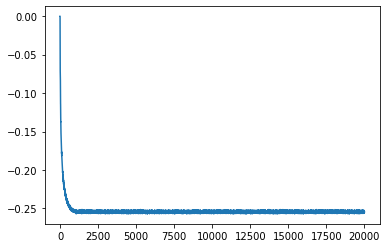

In [182]:
# ACRCD
history = []
grad_x_norms = []
grad_y_norms = []

# y (paper) = q(code_)

def ACRCD(x_0, y_0, K):
    x_list = [x_0]
    y_list = [y_0]

    z1_cur = x_0
    z2_cur = y_0

    q1_cur = x_0
    q2_cur = y_0

#     L1 = L2 = 200
    L1 = 1000 # test_problem.La
    L2 = test_problem.Lb
    beta = 1 / 2

    n_ = L1 ** beta + L2 ** beta

    # q_cur_block (code) = y (paper)
    # z_cur_block (code) = z (paper)
    for i in tqdm(range(K)):

        #####  redefine alpha, tau
        alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)

        x1_upd = tau * z1_cur + (1 - tau) * q1_cur
        x2_upd = tau * z2_cur + (1 - tau) * q2_cur

        # test_problem.x = torch.tensor(x_upd, requires_grad=True)
        # test_problem.y = torch.tensor(y_upd, requires_grad=True)
        result, grad_x, grad_y = test_problem.calc(x1_upd, x2_upd)
        history.append(result.item())
        grad_x_norms.append(np.linalg.norm(grad_x))
        grad_y_norms.append(np.linalg.norm(grad_y))
        #         print(result, torch.norm(grad_x), torch.norm(grad_y))

        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])

        if index_p == 0:
            q1_upd = x1_upd - (1 / L1) * grad_x
            q2_upd = q2_cur

            z1_upd = z1_cur - (1 / L1) * alpha * n_ * grad_x
            z2_upd = z2_cur


        if index_p == 1:
            q1_upd = q1_cur
            q2_upd = x2_upd - (1 / L2) * grad_y

            z1_upd = z1_cur
            z2_upd = z2_cur - (1 / L2) * alpha * n_ * grad_y

        x_list.append(x1_upd)
        y_list.append(x2_upd)

        z1_cur = z1_upd
        z2_cur = z2_upd

        q1_cur = q1_upd
        q2_cur = q2_upd

    return x_list, y_list

# x0 = np.random.random(test_problem.na)
# y0 = np.random.random(test_problem.nb)

x0 = np.zeros(test_problem.x_dim)
y0 = np.zeros(test_problem.y_dim)

x_list_ACRCD, y_list_ACRCD = ACRCD(x0, y0, 20000)

# plt.plot(torch.log(torch.tensor(history)))

plt.plot(torch.tensor(history), label='func')
plt.plot(torch.tensor(grad_x_norms), label='x grad norm')
plt.plot(torch.tensor(grad_y_norms), label='y grad norm')
plt.yscale("log")
plt.legend()
plt.show()
plt.plot(history)
plt.show()

In [178]:
test_problem.calc(x_list_ACRCD[-1], y_list_ACRCD[-1])[0]

array(-0.25473547, dtype=float32)

In [179]:
history[-1]

-0.25473546981811523

In [169]:
# test_problem = TestProblem(gamma=1e-6)

In [170]:
res, x_star, y_star = test_problem.find_solution_by_cvxpy(solver="SCS", verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 09 10:45:01 AM: Your problem has 200 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 09 10:45:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 09 10:45:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 09 10:45:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 09 10:45:02 AM: Compiling problem (target solver=SCS).
(CVXPY) Jul 09 10:45:02 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

C:\Users\iltya\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [171]:
res

17.027392841399905

In [172]:
test_problem.calc(x_star, y_star)

(array(17.027393, dtype=float32),
 array([  9.544968  ,   2.423012  ,   4.0857244 ,  -8.191535  ,
          8.186586  ,  -1.5976859 ,  -3.2094724 ,   1.8337145 ,
         -0.89672315,  -3.832441  ,  10.303616  ,  -0.88509417,
          4.74501   ,   2.0066273 ,  -3.7851908 ,   5.3591933 ,
          5.992865  ,  -5.0531454 ,  -4.9721184 ,  -2.988674  ,
         -1.8501892 ,   6.259315  ,  -3.508811  ,   4.667886  ,
         -2.9109392 ,   1.9308991 ,   3.4994657 ,  -1.0177323 ,
         -4.0860286 ,   1.1327491 ,  -7.2815576 ,   1.6777    ,
         -8.875431  ,   3.5702991 ,  -4.933988  ,   6.663803  ,
          4.2958264 ,  -3.2904723 ,   5.5797887 ,  13.450756  ,
          6.605631  ,  -1.5511262 ,  -2.2869015 ,   8.1053705 ,
         -1.630628  ,  -2.6548562 ,  -4.0425515 ,  11.507848  ,
          3.8995461 ,   8.806193  , -12.840898  ,   0.43188336,
        -14.429236  ,  -5.8205495 ,   6.3982887 ,   2.43546   ,
          5.032802  , -13.6260195 ,   6.228174  ,  -3.928016  ,
      

In [140]:
def get_matrix(m, d, lams):
    """Returns m x d matrix with given min(m, d) singular values"""
    assert len(lams) == min(m, d)
    transpose = True
    if m > d:
        m, d = d, m
        transpose = False

    U = np.random.rand(d, d)
    Qd, _ = np.linalg.qr(U)
    K = Qd[:d, :m]
    K = K @ np.diag(np.sqrt(lams))

    U = np.random.rand(m, m)
    Qm, _ = np.linalg.qr(U)

    A = K @ Qm
    if transpose:
        A = A.T

    return A

In [145]:
def get_matrix(x_dim, y_dim, _):
    return np.random.random((x_dim, y_dim))

In [157]:
a_matrix = get_matrix(300, 300, np.linspace(1e-2, 200, 300))
a_matrix = a_matrix @ a_matrix.T

In [158]:
np.all(a_matrix == a_matrix.T)

True

In [156]:
np.abs(np.array(a_matrix) - np.array(a_matrix).T)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [128]:
test_problem = TestProblem(gamma=1e-6)

In [ ]:
np.array(test_problem.a_matrix)

In [136]:
torch.abs(test_problem.a_matrix - test_problem.a_matrix.T) < 1e-5

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [130]:
test_problem.a_matrix

tensor([[101.3107,   4.5020,   2.4332,  ...,   4.6335,  -1.7776,   2.4324],
        [  4.5020,  97.8663,  -1.9859,  ...,   6.1226,   3.3677, -10.1859],
        [  2.4332,  -1.9859, 101.0541,  ...,   0.6628,   5.7181,  -1.4256],
        ...,
        [  4.6335,   6.1226,   0.6628,  ..., 104.3214,  -3.2559,   3.1437],
        [ -1.7776,   3.3677,   5.7181,  ...,  -3.2559,  90.9328,  -1.1036],
        [  2.4324, -10.1859,  -1.4256,  ...,   3.1437,  -1.1036,  99.7495]])

In [ ]:
a_matrix_ = torch.FloatTensor(get_matrix(300, 300, np.linspace(1e-2, self.La, self.x_dim + self.y_dim))) # b @ torch.transpose(b, 0, 1)

In [ ]:
res_x, *gradients_x = test_problem.calc(x_list_ACRCD[-1], y_list_ACRCD[-1])
res_x

In [100]:
history = []
grad_x1_norms = []
grad_x2_norms = []

# y (paper) = q(code_)
count_one, count_two = 0, 0

def ACRCD_star(x1_0, x2_0, K):
    global count_one, count_two
    ADAPTIVE_DELTA = 1e-8

    x1_list = [x1_0]
    x2_list = [x2_0]

    z1 = y1 = x1_0
    z2 = y2 = x2_0

    L1 = L2 = 5000
    beta = 1 / 2

    for i in tqdm(range(K)):
        tau = 2 / (i + 2)

        x1 = tau * z1 + (1 - tau) * y1
        x2 = tau * z2 + (1 - tau) * y2

#         result, grad_x1, grad_x2 = test_problem.calc(x1, x2)

        res_x, *gradients_x = test_problem.calc(x1, x2) # moved out of the inner loop
        history.append(res_x.item())
        grad_x1_norms.append(np.linalg.norm(gradients_x[0]).item())
        grad_x2_norms.append(np.linalg.norm(gradients_x[1]).item())

        n_ = L1 ** beta + L2 ** beta
        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])
        Ls = [L1, L2]
        Ls[index_p] /= 2

        # ADAPTIVE

        inequal_is_true = False
        xs = [x1, x2]
        sampled_gradient_x = gradients_x[index_p]
        # while not inequal_is_true:
        for j in range(100):
            if index_p == 0:
                count_one += 1
                y1 = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
                y2 = x2
            else:
                count_two += 1
                y2 = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
                y1 = x1
                
            res_y, *_ = test_problem.calc(y1, y2)
                
            inequal_is_true = 1 / (2 * Ls[index_p]) * np.linalg.norm(sampled_gradient_x) ** 2 <= res_x - res_y + ADAPTIVE_DELTA
#             y_minus_x = ([y1, y2][index_p] - xs[index_p])
#             inequal_is_true = (res_y - res_x - gradients_x[index_p] @ y_minus_x 
#                                 <= Ls[index_p] * (y_minus_x ** 2).sum() / 2 + ADAPTIVE_DELTA)
            if inequal_is_true: break
            Ls[index_p] *= 2
#             if Ls[index_p] > 4 * [test_problem.La, test_problem.Lb][index_p]:
#                 print(i, j, index_p, Ls)
#                 print(res_y, res_x)

        L1, L2 = Ls
        n_ = L1 ** beta + L2 ** beta
        alpha = (i + 2) / (2 * n_ ** 2)

        if index_p == 0:
            z1 = z1 - (1 / L1) * alpha * n_ * sampled_gradient_x

        if index_p == 1:
            z2 = z2 - (1 / L2) * alpha * n_ * sampled_gradient_x

        x1_list.append(x1)
        x2_list.append(x2)

    return x1_list, x2_list, [L1, L2]


# np.random.seed(228)
x1_list_ACRCD, x2_list_ACRCD, Ls = ACRCD_star(np.random.random(test_problem.x_dim), np.random.random(test_problem.y_dim), 20000)


array(-0.68670464, dtype=float32)

In [101]:
plt.plot(torch.tensor(history) - f_star, label='func')
plt.plot(torch.tensor(grad_x1_norms), label='x1 grad norm')
plt.plot(torch.tensor(grad_x2_norms), label='x2 grad norm')
plt.yscale("log")
plt.legend()
plt.show()

100%|██████████| 20000/20000 [00:29<00:00, 669.97it/s]


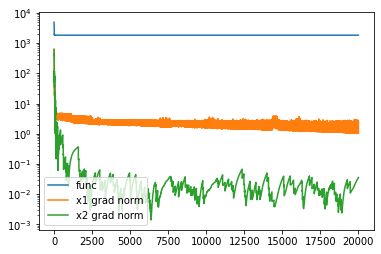

In [102]:
res_x, *gradients_x = test_problem.calc(x1_list_ACRCD[-1], x2_list_ACRCD[-1])
res_x

array(-0.3188041, dtype=float32)

In [ ]:

def get_matrix(m, d, lams):
    """Returns m x d matrix with given min(m, d) singular values"""
    assert len(lams) == min(m, d)
    transpose = True
    if m > d:
        m, d = d, m
        transpose = False

    U = np.random.rand(d, d)
    Qd, _ = np.linalg.qr(U)
    K = Qd[:d, :m]
    K = K @ np.diag(np.sqrt(lams))

    U = np.random.rand(m, m)
    Qm, _ = np.linalg.qr(U)

    A = K @ Qm
    if transpose:
        A = A.T

    return A

## потом удалить

In [112]:
import cvxpy as cp

m = 100
x_dim = 100
y_dim = 200

La = 200
Lb = 1000
gamma = 10

b_vector = np.random.random(m)
c_matrix = np.random.random((m, x_dim))

a_matrix = get_matrix(x_dim + y_dim, x_dim + y_dim,
                      np.linspace(1e-2, La, x_dim + y_dim))
a_matrix = a_matrix @ a_matrix.T

x = cp.Variable(x_dim)
y = cp.Variable(y_dim)

x_y = cp.hstack([x, y])


problem = cp.Problem(cp.Minimize(cp.atoms.quad_form(x_y, a_matrix) + cp.atoms.log_sum_exp((c_matrix @ x - b_vector) / gamma)))


In [113]:
problem.solve()

4.550046001743961

In [114]:
x.value

array([-1.19322515e-02,  1.63183516e-02,  5.18467417e-03,  2.20718016e-02,
       -2.30467800e-02, -4.32870453e-03, -1.85400883e-02, -1.64513615e-02,
       -1.13512511e-02,  2.09566629e-02, -8.09941515e-03,  1.35678661e-02,
        1.44629560e-02,  6.27876145e-03, -1.74538335e-02,  1.08070871e-03,
       -4.92851951e-03,  1.19555895e-02, -1.31738369e-02,  3.85256520e-03,
        4.02444908e-03, -2.10707908e-02, -6.06525210e-03, -1.90839093e-02,
       -1.47898875e-02, -1.96815482e-02,  1.06356480e-02,  1.67127922e-02,
        3.72688718e-03,  1.69131079e-02,  1.82500656e-02, -1.99237075e-03,
       -7.99785338e-03,  1.46542946e-02, -1.16601032e-02, -1.72489043e-02,
       -5.38490166e-03,  4.24853444e-03,  5.71009205e-03, -8.47420455e-03,
       -1.19752669e-03,  7.19397574e-03,  9.13593435e-03,  5.36082058e-03,
       -6.68316034e-03,  4.08946835e-03, -4.20319234e-04, -2.25407215e-02,
        7.79723399e-03, -1.40176025e-02, -2.18142209e-02, -1.96103250e-02,
        1.10083506e-02,  

In [ ]:
    x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)